# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходимо разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не является целью. Цель - правильно разработанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, неправильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [380]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Подгружаем данные

In [333]:
train_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv', sep=';')
test_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv', sep=';')
desc_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv', sep=';')

In [334]:
train_df.head(10)

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,[1-100],10000.0,2,0,0,0,0
5,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,100,5,5,5,[1-100],350000.0,1,0,0,0,0
6,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266,27,7,7,7,[1-100],35000.0,3,0,0,0,0
7,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,31,30,30,30,[1-100],10000.0,2,0,0,0,0
8,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,27,26,26,26,[1-100],10000.0,1,0,0,0,0
9,40,125432000.0,122655000.0,122655000.0,0.0,0.0,2777000.0,-63000.0,2714000.0,579000.0,0.0,2135000.0,0.0,24680000.0,8263000.0,16417000.0,0.0,106000.0,2135000.0,11267000.0,11912000.0,0.0,13000.0,11899000.0,0.0,170,132,15,15,15,(100-500],10000.0,2,0,0,0,0


Описание данных

In [335]:
desc_df.head(50)

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


Данные нам признаки отражают финансовую отчетность компании. Но сами по себе достаточно слабо отражают ее финансовую устойчивость. Для ее отображения из исходных данных рассчитаем финансовые мультипликаторы

In [336]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     32395 non-null  int64  
 1   ar_revenue                    17250 non-null  float64
 2   ar_total_expenses             17250 non-null  float64
 3   ar_sale_cost                  17250 non-null  float64
 4   ar_selling_expenses           17250 non-null  float64
 5   ar_management_expenses        17250 non-null  float64
 6   ar_sale_profit                17250 non-null  float64
 7   ar_balance_of_rvns_and_expns  17250 non-null  float64
 8   ar_profit_before_tax          17250 non-null  float64
 9   ar_taxes                      17250 non-null  float64
 10  ar_other_profit_and_losses    17250 non-null  float64
 11  ar_net_profit                 17250 non-null  float64
 12  ab_immobilized_assets         17250 non-null  float64
 13  a

У нас есть 1 категориальный признак, посмотрим на него

In [337]:
train_df['ul_staff_range'].value_counts()

[1-100]      29281
(100-500]     2757
> 500          357
Name: ul_staff_range, dtype: int64

У него всего 3 значения, которые отражают растущую последовательность, значит можно применить label encoding для его кодирования

In [338]:
le = preprocessing.LabelEncoder()
le.fit(train_df['ul_staff_range'])
train_df['ul_staff_range'] = le.transform(train_df['ul_staff_range'])
test_df['ul_staff_range'] = le.transform(test_df['ul_staff_range'])

In [339]:
train_df.nunique()

record_id                       32395
ar_revenue                      12893
ar_total_expenses               12779
ar_sale_cost                    12664
ar_selling_expenses              1994
ar_management_expenses           1093
ar_sale_profit                   7163
ar_balance_of_rvns_and_expns     5063
ar_profit_before_tax             6526
ar_taxes                         2247
ar_other_profit_and_losses        595
ar_net_profit                    6231
ab_immobilized_assets            3498
ab_mobile_current_assets        11222
ab_inventory                     9143
ab_accounts_receivable           8283
ab_other_current_assets          1210
ab_cash_and_securities           3677
ab_losses                        6175
ab_own_capital                   9090
ab_borrowed_capital             10261
ab_long_term_liabilities         2294
ab_short_term_borrowing          4896
ab_accounts_payable              8797
ab_other_borrowings              1437
bus_age                           315
ogrn_age    

In [340]:
# Удалим признак record_id так как он не несет информативности для нашей задачи
# Так же удалим ul_systematizing_flg, так как у него 1 уникальное значение
train_df = train_df.drop(['record_id','ul_systematizing_flg'],axis = 1)

In [341]:
# Проверим выборку на дубликаты
train_df.duplicated().sum()

5805

In [342]:
train_df = train_df.drop_duplicates()

В наших данных большое содержание пропусков, давайте сгруппироуем объекты по кол-ву пропусков и посмотрим на их кол-во

In [343]:
count_nan_in_objects = pd.DataFrame(train_df.isnull().T.sum()).reset_index().groupby(0).count().reset_index()

In [344]:
count_nan_in_objects.columns = ['Количесвоо пропусков в объекте','Количество объектов с этим количеством пропусков']

In [345]:
count_nan_in_objects

,Количесвоо пропусков в объекте,Количество объектов с этим количеством пропусков
0,0,16375
1,24,10215


ЗАметим, что в нашей выборке можно выделить 2 подвыборки по кол-ву пропусков. Посмотрим на объекты 

In [346]:
# Посмотрим на пример объекта с 24 пропусками
sum_null_in_object = pd.DataFrame(train_df.isnull().T.sum(),columns = ['count_nans'])
ids_with_24_nans = sum_null_in_object.query('count_nans == 24').index
train_df.loc[ids_with_24_nans,:]

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,2,10000.0,5,0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,2,10000.0,2,0,0,0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,100,5,5,5,2,350000.0,1,0,0,0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266,27,7,7,7,2,35000.0,3,0,0,0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,31,30,30,30,2,10000.0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,40,6,6,6,2,10000.0,2,0,0,0
32366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107,107,19,19,19,2,10000.0,1,0,0,0
32383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136,136,23,23,23,2,9408.0,2,0,0,0
32387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237,139,2,2,2,2,161799.0,18,0,0,0


Заметим, что у объектов с 24 пропусками отсутсвует финансовая отчетность. Поэтому эти подмножества стоит рассматривать отдельно. Но перед этим убедимся, что эти подмножества присутсвует и в тестовой выборке

In [347]:
pd.DataFrame(test_df.isnull().T.sum(),columns = ["Кол-во пропусков"]).reset_index().groupby("Кол-во пропусков").count()

,index
Кол-во пропусков,
0,82
24,118


Отлично, группы такие же. Рззделим данные на две подвыборки. Это можно сделать по принципу: 1 группа-0 пропусков, 2 группа - 24 пропуска. Но лучше и проще сделать по наличию одного из финансовых показателей, ведь как мы помним у группы с 24 пропусками отсутсвует финансовая отчетность. Поэтому в нашем случае критерием разделения станет наличие прпуска в параметре ar_revenue

In [348]:
train_df_part_1 = train_df[train_df['ar_revenue'].isnull()]
train_df_part_2 = train_df[~train_df['ar_revenue'].isnull()]

test_records_id_part_1 = test_df[test_df['ar_revenue'].isnull()]['record_id']
test_records_id_part_2 = test_df[~test_df['ar_revenue'].isnull()]['record_id']
test_df = test_df.drop('record_id',axis = 1)
test_df_part_1 = test_df[test_df['ar_revenue'].isnull()]
test_df_part_2 = test_df[~test_df['ar_revenue'].isnull()]

In [349]:
def make_features(frame_input):
    frame = frame_input.copy()
    # Доля дохода, которая учитывает пост-оплату
    frame['frac_post_pay'] = frame['ab_accounts_receivable']/frame['ar_revenue']
    frame['OPEX'] = frame['ar_total_expenses'] - frame['ar_selling_expenses'] - frame["ar_management_expenses"]
    # ДОля операционных расходов
    frame['OER'] = frame['OPEX']/frame['ar_revenue']
    frame['frac_comer_exp'] = frame['ar_selling_expenses' ]/ frame['ar_total_expenses']
    frame['Net_margin'] = frame['ar_net_profit']/frame['ar_revenue']
    frame['gross_profit_margin'] = (frame['ar_revenue'] - frame['ar_sale_cost'])/frame['ar_revenue']
    frame['OP_Margin'] = frame['OPEX']/frame['ar_revenue']
    frame['ROE'] = frame['ar_net_profit']/frame['ab_own_capital']
    frame['ROA'] = frame['ar_net_profit']/(frame['ab_own_capital'] + frame['ab_borrowed_capital'])
    frame['Debt/EBIT'] = (frame['ab_long_term_liabilities'] + frame['ab_other_borrowings'] + frame['ab_short_term_borrowing'])/frame['ar_profit_before_tax']
    frame['Debt_ratio'] = (frame['ab_long_term_liabilities'] + frame['ab_other_borrowings'] + frame['ab_short_term_borrowing'])/(frame['ab_own_capital'] + frame['ab_borrowed_capital'])
    frame['tax_ratio'] = frame['ar_taxes']/frame['ar_profit_before_tax']
    frame['time_gap'] = frame['ab_accounts_payable']/(frame['ab_cash_and_securities']+frame['ab_accounts_receivable'])
    frame['borrowing_balance'] = frame['ab_accounts_receivable']/frame['ab_accounts_payable']
    frame['Debt/Equity'] = (frame['ab_long_term_liabilities'] + frame['ab_other_borrowings'] + frame['ab_short_term_borrowing'])/frame['ab_own_capital']
    frame['current_ratio'] = (frame['ab_mobile_current_assets']+frame['ab_other_current_assets'])/(frame['ab_short_term_borrowing']+frame['ab_other_borrowings'])
    frame['cash_ratio'] = frame['ab_cash_and_securities']/frame['ab_short_term_borrowing']
    frame['fast_pay'] = (frame['ab_cash_and_securities']+frame['ab_accounts_receivable'])/(frame['ab_own_capital'] + frame['ab_borrowed_capital'])
    frame['tumover_ratio'] = frame['ar_revenue']/(frame['ab_own_capital'] + frame['ab_borrowed_capital'])
    return frame

Так как у выборок с суфиксом _part_1 нет финансовой отчетности, то и новые признаки создавать не из чего

In [350]:
train_df_part_2_new_features = make_features(train_df_part_2)
test_df_part_2_new_features = make_features(test_df_part_2)

Проверим кол-во уникальных значений в получившихся выборках

In [351]:
train_df_part_2_new_features.nunique()

ar_revenue                      12893
ar_total_expenses               12779
ar_sale_cost                    12664
ar_selling_expenses              1994
ar_management_expenses           1093
ar_sale_profit                   7163
ar_balance_of_rvns_and_expns     5063
ar_profit_before_tax             6526
ar_taxes                         2247
ar_other_profit_and_losses        595
ar_net_profit                    6231
ab_immobilized_assets            3498
ab_mobile_current_assets        11222
ab_inventory                     9143
ab_accounts_receivable           8283
ab_other_current_assets          1210
ab_cash_and_securities           3677
ab_losses                        6175
ab_own_capital                   9090
ab_borrowed_capital             10261
ab_long_term_liabilities         2294
ab_short_term_borrowing          4896
ab_accounts_payable              8797
ab_other_borrowings              1437
bus_age                           294
ogrn_age                          146
adr_actual_a

Признаков с 1 уникальным значением не найдено

In [352]:
train_df_part_1.nunique()

ar_revenue                        0
ar_total_expenses                 0
ar_sale_cost                      0
ar_selling_expenses               0
ar_management_expenses            0
ar_sale_profit                    0
ar_balance_of_rvns_and_expns      0
ar_profit_before_tax              0
ar_taxes                          0
ar_other_profit_and_losses        0
ar_net_profit                     0
ab_immobilized_assets             0
ab_mobile_current_assets          0
ab_inventory                      0
ab_accounts_receivable            0
ab_other_current_assets           0
ab_cash_and_securities            0
ab_losses                         0
ab_own_capital                    0
ab_borrowed_capital               0
ab_long_term_liabilities          0
ab_short_term_borrowing           0
ab_accounts_payable               0
ab_other_borrowings               0
bus_age                         302
ogrn_age                        148
adr_actual_age                   33
head_actual_age             

Кроме 24 признаков с отсутвием значений есть признак ul_strategic_flg, которых хранит в себе только 1 уникальное значение. Добавим его в список на удаление

Теперь же очистим наши выборки от ненужных столбцов. Для _part_2 это все абсолютные значения финансовых показателей. А для _part_1 это все переменные отвечающие за финансовую отчетность + ul_strategic_flg

In [353]:
# Выборки с фин отчетностью
train_df_part_2_new_features = train_df_part_2_new_features.drop(['ar_revenue','ar_other_profit_and_losses','ar_profit_before_tax', 'ar_taxes', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses','ar_sale_profit', 'ar_balance_of_rvns_and_expns'], axis = 1)
test_df_part_2_new_features = test_df_part_2_new_features.drop(['ar_revenue','ar_other_profit_and_losses','ar_profit_before_tax', 'ar_taxes', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses','ar_sale_profit', 'ar_balance_of_rvns_and_expns'], axis = 1)
# Выборки без фин отчетности
first_24_columns = train_df_part_1.iloc[:,:24].columns.tolist()
train_df_part_1 = train_df_part_1.drop(first_24_columns+['ul_strategic_flg'], axis = 1)
test_df_part_1 = test_df_part_1.drop(first_24_columns+['ul_strategic_flg'], axis = 1)

Посмотрим на новые признаки

In [354]:
train_df_part_2_new_features.head(20)

,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m,frac_post_pay,OPEX,OER,frac_comer_exp,Net_margin,gross_profit_margin,OP_Margin,ROE,ROA,Debt/EBIT,Debt_ratio,tax_ratio,time_gap,borrowing_balance,Debt/Equity,current_ratio,cash_ratio,fast_pay,tumover_ratio
0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,2,50000.0,2,0,0,0,0.042494,48344000.0,0.912220,0.000000,0.022605,0.087780,0.912220,1.806938,0.072452,5.552348,0.686362,0.413894,1.804148,0.497900,17.117647,0.637942,0.022469,0.151618,3.205080
3,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,2,300000.0,1,0,0,0,0.005086,29568000.0,0.922587,0.000000,0.059877,0.077413,0.922587,0.864804,0.326861,1.644304,0.622041,0.135975,0.000000,inf,1.645786,1.162377,0.006846,0.032022,5.458866
4,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,2,10000.0,2,0,0,0,0.020902,14935000.0,0.907461,0.000000,0.043201,0.092539,0.907461,0.057159,0.051830,0.000000,0.000000,0.430745,1.529904,0.268960,0.000000,inf,inf,0.060942,1.199738
9,2135000.0,0.0,24680000.0,8263000.0,16417000.0,0.0,106000.0,2135000.0,11267000.0,11912000.0,0.0,13000.0,11899000.0,0.0,170,132,15,15,15,0,10000.0,2,0,0,0,0.130884,122655000.0,0.977861,0.000000,0.017021,0.022139,0.977861,0.189491,0.092109,0.004790,0.000561,0.213338,0.720148,1.379696,0.001154,1898.461538,8.153846,0.712844,5.411450
10,104000.0,0.0,38004000.0,23189000.0,14815000.0,0.0,449000.0,104000.0,10000.0,38443000.0,0.0,4986000.0,33457000.0,0.0,29,29,4,4,4,2,10000.0,2,0,0,0,0.248699,59331000.0,0.995988,0.000000,0.001746,0.004012,0.995988,10.400000,0.002705,35.112676,0.129665,0.267606,2.191889,0.442807,498.600000,7.622142,0.090052,0.396952,1.549164
11,21608000.0,2094000.0,106180000.0,1180000.0,105000000.0,0.0,557000.0,21608000.0,90313000.0,18518000.0,0.0,7500000.0,11018000.0,0.0,102,102,4,4,4,1,300000.0,2,0,0,0,0.582929,142075000.0,0.788758,0.103724,0.119961,0.211242,0.788758,0.239257,0.198546,0.347094,0.068914,0.000000,0.104380,9.529860,0.083045,14.157333,0.074267,0.969917,1.655089
12,71000.0,1269000.0,35349000.0,28034000.0,7237000.0,78000.0,2008000.0,71000.0,94000.0,38532000.0,2866000.0,0.0,35666000.0,0.0,24,24,7,7,7,2,21000.0,1,0,0,0,0.204580,4710000.0,0.133145,0.830635,0.002007,0.866855,0.133145,0.755319,0.001838,32.202247,0.074199,0.202247,3.857869,0.202910,30.489362,inf,inf,0.239347,0.915834
14,855000.0,0.0,11564000.0,8770000.0,2794000.0,0.0,606000.0,855000.0,865000.0,0.0,0.0,0.0,0.0,0.0,20,20,16,16,16,2,10000.0,1,0,0,0,0.120733,22064000.0,0.953418,0.000000,0.036946,0.046582,0.953418,0.988439,0.988439,0.000000,0.000000,0.200187,0.000000,inf,0.000000,inf,inf,3.930636,26.753757
15,157000.0,0.0,3879000.0,1643000.0,2236000.0,0.0,213000.0,157000.0,219000.0,3873000.0,0.0,2387000.0,1486000.0,0.0,48,48,16,16,16,2,10000.0,1,0,0,0,0.138469,15893000.0,0.984209,0.000000,0.009723,0.015791,0.984209,0.716895,0.038368,12.116751,0.583333,0.203046,0.606778,1.504711,10.899543,1.625052,0.089233,0.598485,3.946237
16,0.0,10000.0,0.0,0.0,0.0,0.0,150000.0,0.0,10000.0,150000.0,0.0,150000.0,0.0,0.0,20,20,4,4,4,2,10000.0,1,0,0,0,0.000000,146000.0,0.169767,0.182482,0.000000,0.830233,0.169767,0.000000,0.000000,inf,0.937500,NaN,0.000000,NaN,15.000000,0.000000,1.000000,0.937500,5.375000


Заметим, что в некоторых новых признаках присутсвуют знаения inf и nan. Их стоит заменить на 0

In [355]:
train_df_part_2_new_features = train_df_part_2_new_features.fillna(0)
test_df_part_2_new_features = test_df_part_2_new_features.fillna(0)

train_df_part_2_new_features = train_df_part_2_new_features.replace(np.inf,0)
test_df_part_2_new_features = test_df_part_2_new_features.replace(np.inf,0)
train_df_part_2_new_features = train_df_part_2_new_features.replace(-np.inf,0)
test_df_part_2_new_features = test_df_part_2_new_features.replace(-np.inf,0)

Отбор признаков на основе IV.

In [356]:
def calc_woe_iv(df, feature, target):
    
    vals = list(df[feature].unique())
    count_all = []
    default = []
    non_default = []
    
    for i in vals:
        count_all.append(len(df[df[feature] == i]))
        default.append(len(df[(df[target] == 1) & (df[feature] == i)]))
        non_default.append(len(df[(df[target] == 0) & (df[feature] == i)]))
    
    data = {'value': vals, 'count_all': count_all, 'default': default, 'non_default': non_default}
    df_woe_iv = pd.DataFrame(data)
        
    df_woe_iv['Distr_non_default'] = df_woe_iv['non_default'] / df_woe_iv['non_default'].sum()
    df_woe_iv['Distr_default'] = df_woe_iv['default'] / df_woe_iv['default'].sum()
    name_woe = 'WoE_' + feature
    df_woe_iv[name_woe] = np.log(df_woe_iv['Distr_non_default'] / df_woe_iv['Distr_default'])
    df_woe_iv = df_woe_iv.replace({name_woe: {np.inf: 0, -np.inf: 0}})
    df_woe_iv['IV'] = (df_woe_iv['Distr_non_default'] - df_woe_iv['Distr_default']) * df_woe_iv[name_woe]
    iv = df_woe_iv['IV'].sum()
    
    return df_woe_iv, iv

In [357]:
# пример использования
res_example_woe = calc_woe_iv(train_df_part_2_new_features, 'ul_branch_cnt', 'default_12m')[0]
res_example_iv = calc_woe_iv(train_df_part_2_new_features, 'ul_branch_cnt', 'default_12m')[1]

In [358]:
res_example_woe

,value,count_all,default,non_default,Distr_non_default,Distr_default,WoE_ul_branch_cnt,IV
0,0,16128,771,15357,0.984486,0.993557,-0.009171,0.000083
1,2,36,0,36,0.002308,0.000000,0.000000,0.000000
2,1,159,5,154,0.009872,0.006443,0.426705,0.001463
3,5,9,0,9,0.000577,0.000000,0.000000,0.000000
4,4,11,0,11,0.000705,0.000000,0.000000,0.000000
5,3,15,0,15,0.000962,0.000000,0.000000,0.000000
6,10,2,0,2,0.000128,0.000000,0.000000,0.000000
7,8,5,0,5,0.000321,0.000000,0.000000,0.000000
8,6,6,0,6,0.000385,0.000000,0.000000,0.000000
9,20,2,0,2,0.000128,0.000000,0.000000,0.000000


In [359]:
print('IV for the feature ul_branch_cnt: {}'.format(res_example_iv))

IV for the feature ul_branch_cnt: 0.0015464149234264888


In [360]:
number_bins = range(1, 20)
ivvv = []

for feature in train_df_part_2_new_features.columns:
    
    if feature == 'default_12m':
        continue
    name = 'cut_' + str(feature)
    for i in number_bins:
        train_df_part_2_new_features[name] = pd.cut(train_df_part_2_new_features[feature], i)
        ivvv.append(calc_woe_iv(train_df_part_2_new_features, name, 'default_12m')[1])

    bin_iv = {}
    for A, B in zip(number_bins, ivvv):
        bin_iv[A] = B
    cut_bin = max(bin_iv, key=bin_iv.get)
    

    train_df_part_2_new_features[name] = pd.cut(train_df_part_2_new_features[feature], cut_bin)
    del train_df_part_2_new_features[feature]

In [361]:
train_df_part_2_new_features

,default_12m,cut_ar_net_profit,cut_ab_immobilized_assets,cut_ab_mobile_current_assets,cut_ab_inventory,cut_ab_accounts_receivable,cut_ab_other_current_assets,cut_ab_cash_and_securities,cut_ab_losses,cut_ab_own_capital,cut_ab_borrowed_capital,cut_ab_long_term_liabilities,cut_ab_short_term_borrowing,cut_ab_accounts_payable,cut_ab_other_borrowings,cut_bus_age,cut_ogrn_age,cut_adr_actual_age,cut_head_actual_age,cut_cap_actual_age,cut_ul_staff_range,cut_ul_capital_sum,cut_ul_founders_cnt,cut_ul_branch_cnt,cut_ul_strategic_flg,cut_frac_post_pay,cut_OPEX,cut_OER,cut_frac_comer_exp,cut_Net_margin,cut_gross_profit_margin,cut_OP_Margin,cut_ROE,cut_ROA,cut_Debt/EBIT,cut_Debt_ratio,cut_tax_ratio,cut_time_gap,cut_borrowing_balance,cut_Debt/Equity,cut_current_ratio,cut_cash_ratio,cut_fast_pay,cut_tumover_ratio
0,0,"(-49314340.0, 32921105.263]","(-1630344.0, 85807578.947]","(-3175805.0, 167147631.579]","(-2890917.0, 152153526.316]","(-13327190.0, 79090210.526]","(-3750035.0, 14325684.211]","(-1271337.0, 66912473.684]","(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(-3349389.0, 176283631.579]","(-5990744.0, 150760631.579]","(-3025074.0, 14409157.895]","(-1820521.0, 95816894.737]","(-1501828.0, 65635684.211]","(188.263, 224.316]","(133.526, 141.263]","(2.684, 4.368]","(2.684, 4.368]","(2.684, 4.368]","(1.895, 2.0]","(-840915.13, 44258691.053]","(0.003, 53.474]","(-0.02, 1.053]","(-0.001, 0.0526]","(-2.293, 73.97]","(27362421.053, 94192473.684]","(-2.316, 6.863]","(-0.001, 0.0526]","(-15.905, 6.6]","(-5.863, 3.145]","(-2.316, 6.863]","(-188.277, 10.734]","(-103.936, 13.289]","(-254.632, 1489.658]","(-5.184, 20.579]","(-10.278, 15.33]","(-13.987, 341.449]","(-12.202, 566.007]","(-160.544, 383.018]","(-239.809, 7738.374]","(-33.021, 658.886]","(-34.561, 63.825]","(-334.224, 501.211]"
3,0,"(-49314340.0, 32921105.263]","(-1630344.0, 85807578.947]","(-3175805.0, 167147631.579]","(-2890917.0, 152153526.316]","(-13327190.0, 79090210.526]","(-3750035.0, 14325684.211]","(-1271337.0, 66912473.684]","(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(-3349389.0, 176283631.579]","(-5990744.0, 150760631.579]","(-3025074.0, 14409157.895]","(-1820521.0, 95816894.737]","(-1501828.0, 65635684.211]","(152.211, 188.263]","(133.526, 141.263]","(7.737, 9.421]","(7.737, 9.421]","(7.737, 9.421]","(1.895, 2.0]","(-840915.13, 44258691.053]","(0.003, 53.474]","(-0.02, 1.053]","(-0.001, 0.0526]","(-2.293, 73.97]","(27362421.053, 94192473.684]","(-2.316, 6.863]","(-0.001, 0.0526]","(-15.905, 6.6]","(-5.863, 3.145]","(-2.316, 6.863]","(-188.277, 10.734]","(-103.936, 13.289]","(-254.632, 1489.658]","(-5.184, 20.579]","(-10.278, 15.33]","(-13.987, 341.449]","(-12.202, 566.007]","(-160.544, 383.018]","(-239.809, 7738.374]","(-33.021, 658.886]","(-34.561, 63.825]","(-334.224, 501.211]"
4,0,"(-49314340.0, 32921105.263]","(-1630344.0, 85807578.947]","(-3175805.0, 167147631.579]","(-2890917.0, 152153526.316]","(-13327190.0, 79090210.526]","(-3750035.0, 14325684.211]","(-1271337.0, 66912473.684]","(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(-3349389.0, 176283631.579]","(-5990744.0, 150760631.579]","(-3025074.0, 14409157.895]","(-1820521.0, 95816894.737]","(-1501828.0, 65635684.211]","(188.263, 224.316]","(133.526, 141.263]","(26.263, 27.947]","(26.263, 27.947]","(26.263, 27.947]","(1.895, 2.0]","(-840915.13, 44258691.053]","(0.003, 53.474]","(-0.02, 1.053]","(-0.001, 0.0526]","(-2.293, 73.97]","(-39467631.579, 27362421.053]","(-2.316, 6.863]","(-0.001, 0.0526]","(-15.905, 6.6]","(-5.863, 3.145]","(-2.316, 6.863]","(-188.277, 10.734]","(-103.936, 13.289]","(-254.632, 1489.658]","(-5.184, 20.579]","(-10.278, 15.33]","(-13.987, 341.449]","(-12.202, 566.007]","(-160.544, 383.018]","(-239.809, 7738.374]","(-33.021, 658.886]","(-34.561, 63.825]","(-334.224, 501.211]"
9,0,"(-49314340.0, 32921105.263]","(-1630344.0, 85807578.947]","(-3175805.0, 167147631.579]","(-2890917.0, 152153526.316]","(-13327190.0, 79090210.526]","(-3750035.0, 14325684.211

In [362]:
def calc_iv_features(df, target):
    ivs = []
    feature_names = df.columns
    for i in feature_names:
        df_woe_iv = calc_woe_iv(df, i, target)[0]
        ivs.append(df_woe_iv['IV'].sum())
    
    data = {'feature_name': feature_names, 'iv': ivs}
    df_iv = pd.DataFrame(data)
    return df_iv

In [363]:
res_feature_iv = calc_iv_features(train_df_part_2_new_features, 'default_12m')

In [364]:
res_feature_iv[res_feature_iv['iv'] > 0.1]

,feature_name,iv
8,cut_ab_losses,0.105468
9,cut_ab_own_capital,0.244801
15,cut_bus_age,0.211274
16,cut_ogrn_age,0.199035
26,cut_OPEX,0.122123


Обычно удаляют признаки, чье IV < 0.1

In [365]:
feat_iv = list(res_feature_iv[res_feature_iv['iv'] >= 0.1]['feature_name']) + ['default_12m']

In [366]:
train_df_part_2_new_features_iv = train_df_part_2_new_features[feat_iv]

In [367]:
train_df_part_2_new_features_iv

,cut_ab_losses,cut_ab_own_capital,cut_bus_age,cut_ogrn_age,cut_OPEX,default_12m
0,"(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(188.263, 224.316]","(133.526, 141.263]","(27362421.053, 94192473.684]",0
3,"(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(152.211, 188.263]","(133.526, 141.263]","(27362421.053, 94192473.684]",0
4,"(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(188.263, 224.316]","(133.526, 141.263]","(-39467631.579, 27362421.053]",0
9,"(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(152.211, 188.263]","(125.789, 133.526]","(94192473.684, 161022526.316]",0
10,"(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(7.315, 44.053]","(25.211, 32.947]","(27362421.053, 94192473.684]",0
...,...,...,...,...,...,...
32388,"(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(80.105, 116.158]","(79.368, 87.105]","(27362421.053, 94192473.684]",0
32390,"(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(44.053, 80.105]","(63.895, 71.632]","(27362421.053, 94192473.684]",0
32391,"(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(152.211, 188.263]","(133.526, 141.263]","(-39467631.579, 27362421.053]",0
32393,"(-1252947.368, 14263736.842]","(-76824889.0, 20510473.684]","(44.053, 80.105]","(63.895, 71.632]","(94192473.684, 161022526.316]",1


In [368]:
for feature in train_df_part_2_new_features_iv:
    if feature == 'default_12m':
        continue
    temp = calc_woe_iv(train_df_part_2_new_features_iv, feature, 'default_12m')[0]
    res = train_df_part_2_new_features_iv.merge(temp, how='left', left_on=feature, right_on = 'value')
    del res['value']
    train_df_part_2_new_features_iv = res.copy()

train_df_part_2_new_features_iv_fin = train_df_part_2_new_features_iv[['WoE_cut_ab_losses', 'WoE_cut_ab_own_capital', 
                                                                      'WoE_cut_bus_age', 'WoE_cut_ogrn_age', 'default_12m']]

In [369]:
train_df_part_2_new_features_iv_fin

,WoE_cut_ab_losses,WoE_cut_ab_own_capital,WoE_cut_bus_age,WoE_cut_ogrn_age,default_12m
0,-0.060878,-0.185442,0.635523,0.459748,0
1,-0.060878,-0.185442,0.434920,0.459748,0
2,-0.060878,-0.185442,0.635523,0.459748,0
3,-0.060878,-0.185442,0.434920,0.706237,0
4,-0.060878,-0.185442,-0.576431,-0.636093,0
...,...,...,...,...,...
16370,-0.060878,-0.185442,0.174355,0.156979,0
16371,-0.060878,-0.185442,-0.200397,0.366486,0
16372,-0.060878,-0.185442,0.434920,0.459748,0
16373,-0.060878,-0.185442,-0.200397,0.366486,1


In [257]:
def find_correlated_features(df_, threshold):
    corr_matrix = df_.corr().abs()
    corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
    df_ = corr_matrix.stack().reset_index()
    df_.columns = ['feature1', 'feature2', 'corr_coef']
    df_ = df_[df_.corr_coef >= threshold].sort_values('corr_coef', ascending=False)
    return df_

In [372]:
find_correlated_features(train_df_part_2_new_features_iv_fin, 0.8)

,feature1,feature2,corr_coef
7,WoE_cut_bus_age,WoE_cut_ogrn_age,0.810469


In [373]:
X_train_part_iv = train_df_part_2_new_features_iv_fin.drop('default_12m',axis = 1) 
y_train_part_iv = train_df_part_2_new_features_iv_fin['default_12m']

In [383]:
def RFE_feature_selection(clf_lr, X, y):
    rfecv = RFECV(estimator=clf_lr, step=1, cv=StratifiedKFold(5), verbose=0, scoring='roc_auc')
    rfecv.fit(X, y)
    print("Оптимальное количество признаков : %d" % rfecv.n_features_)
    f, ax = plt.subplots(figsize=(10, 8))
    plt.xlabel("Количество выбранных признаков")
    plt.ylabel("Cross validation score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

Оптимальное количество признаков : 4


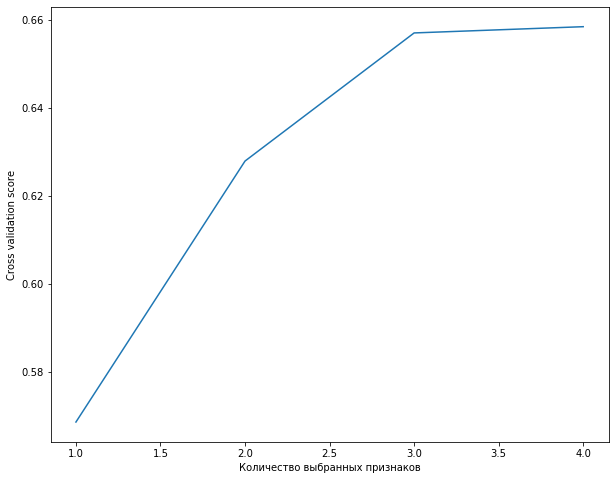

In [384]:
RFE_feature_selection(LogisticRegression(max_iter=1000), X_train_part_iv , y_train_part_iv)

In [28]:
def filter_function(X_train,y_train,column_target):
    """
    Функция вычисления t статистики
    """
    grouped = X_train.merge(y_train,left_index=True,right_index=True).groupby(column_target)
    mean_neg = grouped.mean().iloc[0]
    mean_pos = grouped.mean().iloc[1]
    std_neg = grouped.std().iloc[0]
    std_pos = grouped.std().iloc[1]
    count_neg = grouped.count().iloc[0]
    count_pos = grouped.count().iloc[1]
    t = np.abs(mean_pos - mean_neg)/np.sqrt((count_pos*std_pos**2 + count_neg*std_neg**2)/(count_pos+count_neg))
    return t

In [29]:
X_train_part_2 = train_df_part_2_new_features.drop('default_12m',axis = 1) 
y_train_part_2 = train_df_part_2_new_features['default_12m']

X_train_part_1 = train_df_part_1.drop('default_12m',axis = 1) 
y_train_part_1 = train_df_part_1['default_12m']

In [30]:
top_features_part_2 =pd.DataFrame(data = filter_function(X_train_part_2,y_train_part_2,'default_12m').to_dict().items())

In [31]:
top_features_part_2 = top_features_part_2.sort_values(by = 1, ascending=False).reset_index(drop = True)[:25][0].tolist()

In [32]:
top_features_part_1 =pd.DataFrame(data = filter_function(X_train_part_1,y_train_part_1,'default_12m').to_dict().items())

In [33]:
top_features_part_1 = top_features_part_1.sort_values(by = 1, ascending=False).reset_index(drop = True)[:7][0].tolist()

In [ ]:
steps = [('smote',SMOTE(random_state=42)),('stand',StandardScaler()), ('model', LogisticRegression(max_iter=1000))]
LGREG = Pipeline(steps=steps)

# Зададим диапазон перебора параметра
parametrs_Logreg = {'model__C':np.logspace(0,-5,20),'smote__k_neighbors':range(2,12)}
# parametrs_Logreg = {'model__C':[0.0006951927961775605],'smote__k_neighbors':[9]}
# Инициализируем кросс-валидационный перебор параметра
grid_Logreg_part_2 = GridSearchCV(LGREG,parametrs_Logreg,scoring='accuracy')
# Обучим модель
grid_Logreg_part_2.fit(X_train_part_2.loc[:,top_features_part_2],y_train_part_2)

In [32]:
grid_Logreg_part_2.best_score_

0.5852213740458015

In [33]:
grid_Logreg_part_2.best_params_

{'model__C': 0.000379269019073225, 'smote__k_neighbors': 10}

In [34]:
y_train_part_2.value_counts(normalize=True)

0    0.952611
1    0.047389
Name: default_12m, dtype: float64

In [85]:
steps = [('smote',SMOTE(random_state=42)),('stand',StandardScaler()), ('model', LogisticRegression(max_iter=1000))]
LGREG = Pipeline(steps=steps)

# Зададим диапазон перебора параметра
parametrs_Logreg = {'model__C':np.logspace(0,-5,20),'smote__k_neighbors':range(2,12)}
# Инициализируем кросс-валидационный перебор параметра
grid_Logreg_part_1 = GridSearchCV(LGREG,parametrs_Logreg,scoring='accuracy')
# Обучим модель
grid_Logreg_part_1.fit(X_train_part_1.loc[:,top_features_part_1],y_train_part_1)

GridSearchCV(estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('stand', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'model__C': array([1.00000000e+00, 5.45559478e-01, 2.97635144e-01, 1.62377674e-01,
       8.85866790e-02, 4.83293024e-02, 2.63665090e-02, 1.43844989e-02,
       7.84759970e-03, 4.28133240e-03, 2.33572147e-03, 1.27427499e-03,
       6.95192796e-04, 3.79269019e-04, 2.06913808e-04, 1.12883789e-04,
       6.15848211e-05, 3.35981829e-05, 1.83298071e-05, 1.00000000e-05]),
                         'smote__k_neighbors': range(2, 12)},
             scoring='accuracy')

In [86]:
grid_Logreg_part_1.best_score_

0.6191874694077337

In [38]:
grid_Logreg_part_1.best_params_

{'model__C': 1.0, 'smote__k_neighbors': 4}

In [72]:
preds_part_2 = grid_Logreg_part_2.predict_proba(test_df_part_2_new_features.loc[:,top_features_part_2])
preds_part_1 = grid_Logreg_part_1.predict_proba(test_df_part_1.loc[:,top_features_part_1])

In [78]:
answ_part_1 = pd.DataFrame()
answ_part_1['id'] = test_records_id_part_1
answ_part_1['predict'] = preds_part_1

answ_part_2 = pd.DataFrame()
answ_part_2['id'] = test_records_id_part_2
answ_part_2['predict'] = preds_part_2

answ_df = pd.concat([answ_part_2,answ_part_1],sort=False)

In [79]:
answ_df = answ_df.reset_index(drop = True)

In [80]:
answ_df

,id,predict
0,196,1
1,2813,1
2,4385,1
3,6479,1
4,6726,1
5,21939,1
6,24652,1
7,26235,1
8,29016,1
9,29405,1


In [82]:
answ_df.to_csv('PD-submit_features_low_thr.csv',index=False, sep=';')